In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

In [2]:
direc = Path('C:\\projects\\all-projects\\vislearn\\fish\\Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,C:\projects\all-projects\vislearn\fish\Fish_Da...,Black Sea Sprat
1,C:\projects\all-projects\vislearn\fish\Fish_Da...,Gilt-Head Bream
2,C:\projects\all-projects\vislearn\fish\Fish_Da...,Gilt-Head Bream
3,C:\projects\all-projects\vislearn\fish\Fish_Da...,Red Mullet
4,C:\projects\all-projects\vislearn\fish\Fish_Da...,Red Sea Bream


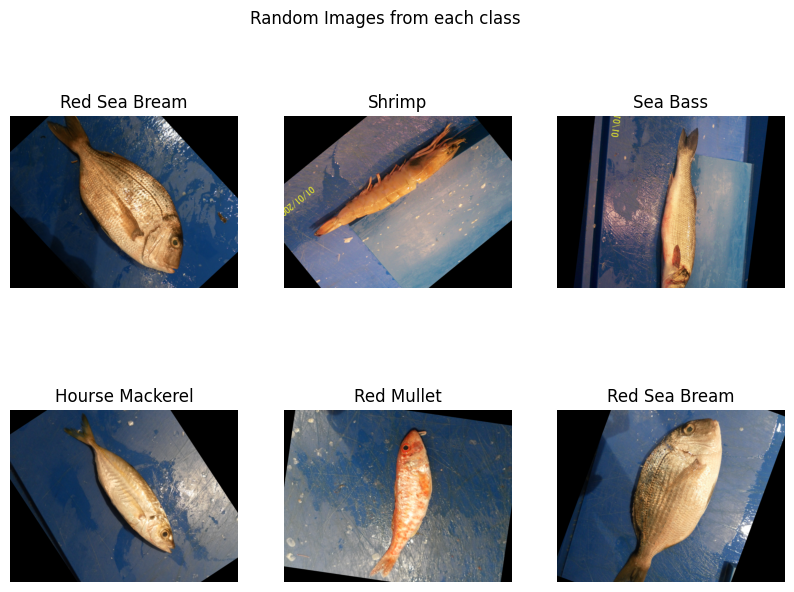

In [3]:
#show 6 random images and their labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
fig, ax = plt.subplots(2,3, figsize=(10,7))
fig.suptitle('Random Images from each class')
for i in range(2):
    for j in range(3):
        r = random.randint(0, img_df.shape[0]-1)
        ax[i,j].imshow(mpimg.imread(img_df.loc[r,'FilePaths']))
        ax[i,j].set_title(img_df.loc[r,'Labels'])
        ax[i,j].axis('off')

In [4]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


In [5]:
img_df['Labels'].value_counts(ascending=True)

Labels
Black Sea Sprat       1000
Gilt-Head Bream       1000
Red Mullet            1000
Red Sea Bream         1000
Striped Red Mullet    1000
Sea Bass              1000
Hourse Mackerel       1000
Trout                 1000
Shrimp                1000
Name: count, dtype: int64

In [6]:
#splitting the data into train and test
train_df, test_df = train_test_split(img_df, train_size=0.7, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f" Count of Rows : {train_df.shape[0]} \n Count of Columns : {train_df.shape[1]} ")
print(f" Count of Rows : {test_df.shape[0]} \n Count of Columns : {test_df.shape[1]} ")


 Count of Rows : 6300 
 Count of Columns : 2 
 Count of Rows : 2700 
 Count of Columns : 2 


In [7]:
#creating the model in pytorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [8]:
#creating a custom dataset
class FishDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx,'FilePaths']
        image = Image.open(img_path)
        label = self.df.loc[idx,'Labels']
        if self.transform:
            image = self.transform(image)
        return image, label
    
#creating the transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [9]:
#creating the datasets
train_dataset = FishDataset(train_df, train_transform)
test_dataset = FishDataset(test_df, test_transform)


In [10]:
#creating the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [20]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

# Check for the availability of CUDA (GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating the model
model = torchvision.models.resnet50(pretrained=True)
model = model.to(device)
model.fc = nn.Linear(2048, 9)

# Creating the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)  # Move data to the GPU
        target = target.to(device)  # Move target to the GPU
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    losses.append(train_loss / len(train_loader))
    print(f"Epoch : {epoch + 1} \t Loss : {train_loss / len(train_loader)}")

# Plotting the losses
plt.plot(losses)
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


AttributeError: 'tuple' object has no attribute 'to'